In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, make_scorer, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.inspection import permutation_importance

In [2]:
def build_clustering_dataset_optimized(
    data,
    lepol_time,
    kiln_time,
    refroidisseur_time,
    type="mean",
    tol=0.01,
    include_std=False
):
    data = data.copy()
    data.index = pd.to_datetime(data.index)
    data = data[~data.index.duplicated(keep='first')]

    total_window = lepol_time + kiln_time + refroidisseur_time

    lepol_features = [
        'Température sur chambre chaude ',
        'Temperature Air Secondaire',
        'Oxygene Sortie Four',
        'NOx Sortie Four',
        'SO2 Sortie Four',
        'CO Sortie Four'
    ]

    kiln_features = [
        'Intensite Moteur Four',
        'Temperature Zone'
    ]

    input_features = [
        'Debit moyen entree farine Four  (CF)',
        'Debit Injection SQ7',
        'Debit moyen SOLVEN in Kiln'
    ]

    min_time = data.index.min()
    max_time = data.index.max()
    full_range = pd.date_range(start=min_time, end=max_time, freq='min')
    data_reindexed = data.reindex(full_range)

    valid_mask = data_reindexed.index.isin(data.index)

    quality_arr = data_reindexed['Mesure traitee CaOl Alcatron'].values
    input_arrays = {col: data_reindexed[col].values for col in input_features}
    lepol_arrays = {col: data_reindexed[col].values for col in lepol_features}
    kiln_arrays = {col: data_reindexed[col].values for col in kiln_features}

    max_start_idx = len(data_reindexed) - total_window - 1
    if max_start_idx < 0:
        return pd.DataFrame()

    valid_starts = []
    for i in range(max_start_idx + 1):
        lepol_end = i + lepol_time
        kiln_end = lepol_end + kiln_time
        refroid_idx = i + total_window
        if (refroid_idx < len(valid_mask) and
            valid_mask[i:lepol_end + 1].all() and
            valid_mask[lepol_end:kiln_end + 1].all() and
            valid_mask[refroid_idx]):
            valid_starts.append(i)

    if not valid_starts:
        return pd.DataFrame()

    valid_starts = np.array(valid_starts)
    n_windows = len(valid_starts)
    end_indices = valid_starts + total_window
    end_times = full_range[end_indices]

    print(f"Building {n_windows} valid windows...")

    result_dict = {
        'Time': end_times,
        'Mesure traitee CaOl Alcatron': quality_arr[end_indices]
    }

    # input features at start
    for col in input_features:
        result_dict[col] = input_arrays[col][valid_starts]

    # lepol / kiln features
    if type in ["mean", "mean_std"]:
        for col in lepol_features:
            arr = lepol_arrays[col]
            means = np.empty(n_windows, dtype=float)
            stds = np.empty(n_windows, dtype=float) if include_std else None
            for j, start_idx in enumerate(valid_starts):
                segment = arr[start_idx:start_idx + lepol_time + 1]
                means[j] = np.nanmean(segment)
                if include_std:
                    stds[j] = np.nanstd(segment)
            result_dict[f"{col}_lepol_mean"] = means
            if include_std:
                result_dict[f"{col}_lepol_std"] = stds

        for col in kiln_features:
            arr = kiln_arrays[col]
            means = np.empty(n_windows, dtype=float)
            stds = np.empty(n_windows, dtype=float) if include_std else None
            for j, start_idx in enumerate(valid_starts):
                kstart = start_idx + lepol_time
                segment = arr[kstart:kstart + kiln_time + 1]
                means[j] = np.nanmean(segment)
                if include_std:
                    stds[j] = np.nanstd(segment)
            result_dict[f"{col}_kiln_mean"] = means
            if include_std:
                result_dict[f"{col}_kiln_std"] = stds

    elif type == "segment":
        # Lepol features
        for col in lepol_features:
            arr = lepol_arrays[col]
            for i in range(lepol_time + 1):
                result_dict[f"{col}_lepol_t{i}"] = [arr[start_idx + i] for start_idx in valid_starts]
    
        # Kiln features
        for col in kiln_features:
            arr = kiln_arrays[col]
            for i in range(kiln_time + 1):
                result_dict[f"{col}_kiln_t{i}"] = [arr[start_idx + lepol_time + i] for start_idx in valid_starts]

    clustering_data = pd.DataFrame(result_dict)
    clustering_data.set_index("Time", inplace=True)

    labels_arr = np.full(n_windows, -1, dtype=int)
    curr_idx = end_indices
    prev_idx = curr_idx - 1
    valid_prev = (prev_idx >= 0) & valid_mask[prev_idx]

    if valid_prev.any():
        curr_vals = quality_arr[curr_idx[valid_prev]]
        prev_vals = quality_arr[prev_idx[valid_prev]]
        ok_vals = (~np.isnan(curr_vals)) & (~np.isnan(prev_vals)) & (curr_vals != 0) & (prev_vals != 0)
        label_mask = ok_vals & (np.abs(curr_vals - prev_vals) > tol)
        labels = np.where(curr_vals[label_mask] <= 3.5, 1, 0)
        positions = np.flatnonzero(valid_prev)
        label_positions = positions[label_mask]
        labels_arr[label_positions] = labels

    clustering_data['Labels'] = labels_arr
    return clustering_data


In [3]:
csv_path = "/Users/foucauld/Desktop/stage_centre_Borelli/Clean_code/Clustering/clean_raw_data.csv"

data = pd.read_csv(csv_path, sep=',')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)
print(len(data))
# Keep the first row for each timestamp
data = data[~data.index.duplicated(keep='first')]
print(len(data))

96358
94919


In [4]:
clustering_data_optimal_time_mean_std = build_clustering_dataset_optimized(data, lepol_time=20, kiln_time=30, refroidisseur_time=40, type="mean",tol=0.01, include_std=True)
clustering_data_optimal_time_mean = build_clustering_dataset_optimized(data, lepol_time=20, kiln_time=30, refroidisseur_time=40, type="mean",tol=0.01, include_std=False)
clustering_data_optimal_time_segment = build_clustering_dataset_optimized(data, lepol_time=20, kiln_time=30, refroidisseur_time=40, type="segment",tol=0.01, include_std=False)

Building 94649 valid windows...
Building 94649 valid windows...
Building 94649 valid windows...


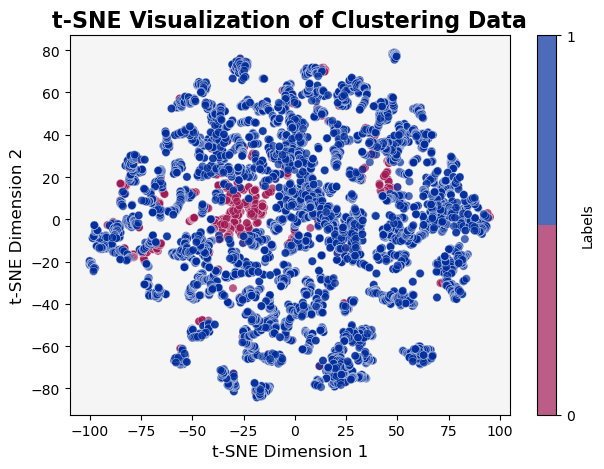

In [5]:
class_0 = clustering_data_optimal_time_mean[clustering_data_optimal_time_mean['Labels'] == 0]
class_1 = clustering_data_optimal_time_mean[clustering_data_optimal_time_mean['Labels'] == 1]

labellised_data = pd.concat([class_0, class_1])

X = labellised_data.drop(columns=['Labels'])
y = labellised_data['Labels']

scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns, index=X.index)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

colors = ['#9f1853', '#002d9c']  # dark blue for class 0, reddish pink for class 1
scatter = plt.scatter(
    X_tsne[:, 0], 
    X_tsne[:, 1], 
    c=y, 
    cmap=plt.matplotlib.colors.ListedColormap(colors), 
    alpha=0.7, 
    edgecolors='w', 
    linewidth=0.3
)

plt.title("t-SNE Visualization of Clustering Data", fontsize=16, weight='bold')
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.grid(False)
plt.gca().set_facecolor('#F5F5F5')  # light grey background for contrast
plt.colorbar(scatter, ticks=[0, 1], label='Labels')
plt.tight_layout()
plt.show()

In [6]:
count_0_mean_std = (clustering_data_optimal_time_mean_std['Labels'] == 0).sum()
count_1_mean_std = (clustering_data_optimal_time_mean_std['Labels'] == 1).sum()
if count_0_mean_std == 0 or count_1_mean_std == 0:
    print("Skipping: one class has 0 samples")

class_0_mean_std = clustering_data_optimal_time_mean_std[clustering_data_optimal_time_mean_std['Labels'] == 0]
class_1_mean_std = clustering_data_optimal_time_mean_std[clustering_data_optimal_time_mean_std['Labels'] == 1]
class_1_downsampled_mean_std = class_1_mean_std.sample(count_0_mean_std, random_state=42)
balanced_data_mean_std = pd.concat([class_0_mean_std, class_1_downsampled_mean_std])

X_mean_std = balanced_data_mean_std.drop(columns=['Labels', 'Mesure traitee CaOl Alcatron'])
y_mean_std = balanced_data_mean_std['Labels']

scaler = StandardScaler()
X_scaled_mean_std = scaler.fit_transform(X_mean_std)

X_train_mean_std, X_test_mean_std, y_train_mean_std, y_test_mean_std = train_test_split(
    X_scaled_mean_std, y_mean_std, test_size=0.2, random_state=42, stratify=y_mean_std, shuffle=True
)

In [7]:
count_0_mean = (clustering_data_optimal_time_mean['Labels'] == 0).sum()
count_1_mean = (clustering_data_optimal_time_mean['Labels'] == 1).sum()
if count_0_mean == 0 or count_1_mean == 0:
    print("Skipping: one class has 0 samples")

class_0_mean = clustering_data_optimal_time_mean[clustering_data_optimal_time_mean['Labels'] == 0]
class_1_mean = clustering_data_optimal_time_mean[clustering_data_optimal_time_mean['Labels'] == 1]
class_1_downsampled_mean = class_1_mean.sample(count_0_mean, random_state=42)
balanced_data_mean = pd.concat([class_0_mean, class_1_downsampled_mean])

X_mean = balanced_data_mean.drop(columns=['Labels', 'Mesure traitee CaOl Alcatron'])
y_mean = balanced_data_mean['Labels']

scaler = StandardScaler()
X_scaled_mean = scaler.fit_transform(X_mean)

X_train_mean, X_test_mean, y_train_mean, y_test_mean = train_test_split(
    X_scaled_mean, y_mean, test_size=0.2, random_state=42, stratify=y_mean, shuffle=True
)

In [8]:
count_0 = (clustering_data_optimal_time_segment['Labels'] == 0).sum()
count_1 = (clustering_data_optimal_time_segment['Labels'] == 1).sum()
if count_0 == 0 or count_1 == 0:
    print("Skipping: one class has 0 samples")

class_0 = clustering_data_optimal_time_segment[clustering_data_optimal_time_segment['Labels'] == 0]
class_1 = clustering_data_optimal_time_segment[clustering_data_optimal_time_segment['Labels'] == 1]
class_1_downsampled = class_1.sample(count_0, random_state=42)
balanced_data = pd.concat([class_0, class_1_downsampled])

X = balanced_data.drop(columns=['Labels', 'Mesure traitee CaOl Alcatron'])
y = balanced_data['Labels']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
)

In [9]:
best_gb_mean_std = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=1,
    subsample=0.9,
    max_features='sqrt',
    random_state=42
)

best_gb_mean = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=1,
    subsample=0.9,
    max_features='sqrt',
    random_state=42
)

best_gb_segment = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=1,
    subsample=0.9,
    max_features='sqrt',
    random_state=42
)

# Use StratifiedKFold to preserve class distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Compute cross-validated F1 scores
f1_scorer = make_scorer(f1_score) 

print("GB trained on mean + std")
cv_scores_mean_std = cross_val_score(best_gb_mean_std, X_train_mean_std, y_train_mean_std, cv=cv, scoring=f1_scorer)

print("Cross-validated F1 scores:", cv_scores_mean_std)
print("Mean CV F1:", cv_scores_mean_std.mean())
print("Std CV F1:", cv_scores_mean_std.std())

best_gb_mean_std.fit(X_train_mean_std, y_train_mean_std)
y_test_pred_mean_std = best_gb_mean_std.predict(X_test_mean_std)
test_f1_mean_std = f1_score(y_test_mean_std, y_test_pred_mean_std)
print("Test F1 Score for mean + std:", test_f1_mean_std)
print("----------------------")

print("GB trained on mean")
cv_scores_mean = cross_val_score(best_gb_mean, X_train_mean, y_train_mean, cv=cv, scoring=f1_scorer)
print("Cross-validated F1 scores:", cv_scores_mean)
print("Mean CV F1:", cv_scores_mean.mean())
print("Std CV F1:", cv_scores_mean.std())

best_gb_mean.fit(X_train_mean, y_train_mean)
y_test_pred_mean = best_gb_mean.predict(X_test_mean)
test_f1_mean = f1_score(y_test_mean, y_test_pred_mean)
print("Test F1 Score for mean:", test_f1_mean)
print("----------------------")

print("GB trained on segments")
cv_scores = cross_val_score(best_gb_segment, X_train, y_train, cv=cv, scoring=f1_scorer)
print("Cross-validated F1 scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())
print("Std CV F1:", cv_scores.std())

best_gb_segment.fit(X_train, y_train)
y_test_pred = best_gb_segment.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred)
print("Test F1 Score for segments:", test_f1)

GB trained on mean + std
Cross-validated F1 scores: [0.74889868 0.79831933 0.75221239 0.81512605 0.78947368]
Mean CV F1: 0.780806026031283
Std CV F1: 0.026059098210312645
Test F1 Score for mean + std: 0.8054607508532423
----------------------
GB trained on mean
Cross-validated F1 scores: [0.77391304 0.78813559 0.76315789 0.82251082 0.78026906]
Mean CV F1: 0.7855972824484457
Std CV F1: 0.020186579677174372
Test F1 Score for mean: 0.8013468013468014
----------------------
GB trained on segments
Cross-validated F1 scores: [0.74458874 0.77253219 0.76521739 0.77637131 0.73873874]
Mean CV F1: 0.759489674297982
Std CV F1: 0.015103261353214827
Test F1 Score for segments: 0.821917808219178


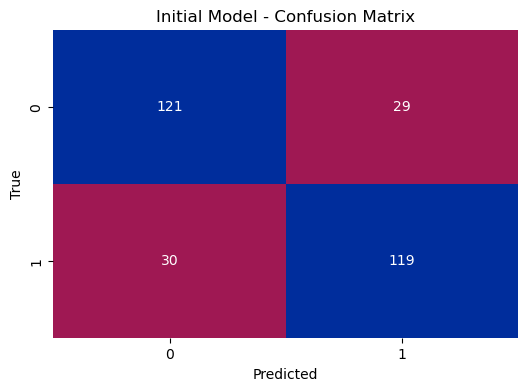

In [10]:
cm = confusion_matrix(y_test_mean, y_test_pred_mean)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.matplotlib.colors.ListedColormap(colors), cbar=False)
plt.title('Initial Model - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

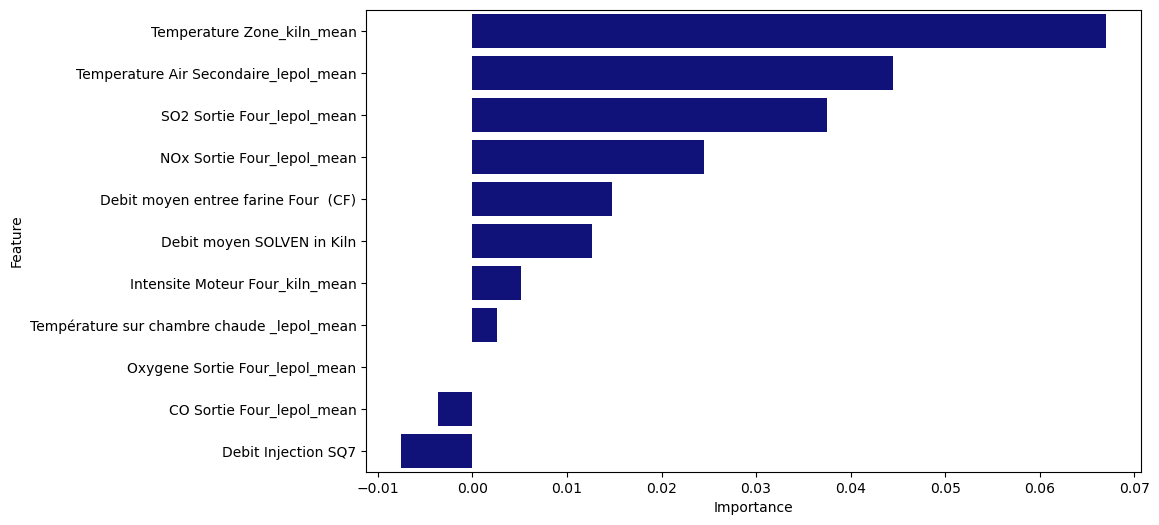

In [11]:
result = permutation_importance(best_gb_mean, X_test_mean, y_test_mean, n_repeats=10, random_state=42, scoring=f1_scorer)

importances = result.importances_mean
feature_names = clustering_data_optimal_time_mean.drop(columns=["Labels", "Mesure traitee CaOl Alcatron"]).columns

feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', color="darkblue" ,data=feature_importances)
#plt.title('Feature Importances from Permutation Importance')
plt.show()